<a href="https://colab.research.google.com/github/leticiatdoliveira/GAN-getting-started/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement

**Goal**: Create a conditional GAN

**Dataset**: [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) from kaggle

  - Images of 28x28 pixels
  - Grayscale
  - 60000 images to training
  - 10000 images to test
  - 10 classes


# Concepts

Conditional GANs restricts to one class, we aims to create diverse and quality data from a specific class

> We must pass the random label + seed to the Generator, who creates random label + fake data

> We must pass the label + data to the Discriminator

# Requirements

In [1]:
!pip install q kaggle

In [2]:
from google.colab import files

In [3]:
import os

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt

#Download Dataset from Kaggle

In [5]:
if not os.path.exists('/content/kaggle.json'):
  files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
else:
  print("Kaggle.json already exists")

Saving kaggle.json to kaggle.json


In [6]:
if not os.path.exists('/content/fashion-mnist'):
  !kaggle datasets download -d zalando-research/fashionmnist -p "/content/fashion-mnist"
  !unzip "/content/fashion-mnist/fashionmnist.zip" -d "/content/fashion-mnist"
else:
  print("Dataset already downloaded")


Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 92% 63.0M/68.8M [00:02<00:00, 30.3MB/s]
100% 68.8M/68.8M [00:02<00:00, 26.7MB/s]
Archive:  /content/fashion-mnist/fashionmnist.zip
  inflating: /content/fashion-mnist/fashion-mnist_test.csv  
  inflating: /content/fashion-mnist/fashion-mnist_train.csv  
  inflating: /content/fashion-mnist/t10k-images-idx3-ubyte  
  inflating: /content/fashion-mnist/t10k-labels-idx1-ubyte  
  inflating: /content/fashion-mnist/train-images-idx3-ubyte  
  inflating: /content/fashion-mnist/train-labels-idx1-ubyte  


# Dataset class

In [7]:
class FMNISTDataset(Dataset):
  def __init__(self,csv_file):
    path = '/content/fashion-mnist/' + csv_file
    self.df = pd.read_csv(path)
    self.nb_target = 10
    self.img_width = 28
    self.img_height = 28
    self.img_channels = 1
    pass

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    # get item from an index
    label= self.df.iloc[idx,0]

    # transform label to an one-shot vector
    target = torch.zeros(self.nb_target)
    target[label] = 1

    # get normalized pixel values
    image_values = torch.torch.FloatTensor(self.df.iloc[idx,1:].values) / 255.0

    return image_values, label, target

  def head(self):
    return self.df.head()

  def tail(self):
    return self.df.tail()

  def plot_image(self,idx):
    image_values = self.df.iloc[idx,1:].values
    label = self.df.iloc[idx,0]
    plt.imshow(image_values.reshape(self.img_width,self.img_height),cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()


# Discriminator class


> In forward function, we'll concatenate the image values with the label (one-shot vector) to act as model inputs

In [8]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784+10, 200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),

        nn.Linear(200,1),
        nn.Sigmoid()
      )

    self.loss_function = nn.BCELoss()

    self.optmimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0
    self.progress = []
    self.step_progress_save = 10
    self.step_progress_print = 10000

    pass


  def forward(self,img_tensor,label_tensor):
    inputs = torch.cat((img_tensor, label_tensor))
    return self.model(inputs)


  def train(self, inputs, label_tensor, targets):
    outputs = self.forward(inputs,label_tensor)

    loss = self.loss_function(outputs,targets)

    self.optmimiser.zero_grad()
    loss.backward()
    self.optmimiser.step()

    self.counter += 1
    if (self.counter % self.step_progress_save == 0):
      self.progress.append(loss.item())
    if (self.counter % self.step_progress_print == 0):
      print(f'Loss at step {self.counter}: {loss.item()}')

    pass

  def plot_progress(self):
    df = pd.DataFrame(self.progress,columns=['loss'])
    df.plot(ylim=(0,1),
            figsize=(16,8),
            alpha=0.1,
            marker='.',
            grid=True,
            yticks=(0,0.25,0.))

In train method:
- We must clean the gradients calculated from previous training step [```self.optmimizer.zero_grad()```]
- We must compute the gradients to current loss [```loss.backward()```]
  - It calculates how much each parameter contributes to the loss
- We must updated the model parameters within the new gradient calcul [```self.optmimizer.step()```]

# Generator class

> We don't define a loss function for Generator, it takes the Discriminator's loss function

The generator must be a mirror of the Discriminatior neural network.

In [9]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(1+10, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,784),
        nn.Sigmoid()
      )

    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0
    self.progress = []
    self.step_progress_save = 10

    pass


  def forward(self, seed_tensor, label_tensor):
    inputs = torch.cat((seed_tensor, label_tensor))
    return self.model(inputs)


  def train(self, D, inputs, label, target):
    # calculate network output
    g_output = self.forward(inputs, label)

    # pass output to Discriminator and calculate error
    d_output = D.forward(g_output, label)
    loss = D.loss_function(d_output, target)

    # increase counter and accumulate error every 10
    self.counter += 1;
    if (self.counter % self.step_progress_save == 0):
      self.progress.append(loss.item())
      pass

    # zero gradients, perform a backward pass, update weights
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass

  def plot_progress(self):
    df = pd.DataFrame(self.progress,columns=['loss'])
    df.plot(ylim=(0,1),
            figsize=(16,8),
            alpha=0.1,
            marker='.',
            grid=True,
            yticks=(0,0.25,0.))

  def plot_images(self, label):
    label_tensor = torch.zeros(10)
    label_tensor[label] = 1.0
    # plot a 3 column, 2 row array of sample images
    f, axarr = plt.subplots(2,3, figsize=(16,8))
    for i in range(2):
        for j in range(3):
            axarr[i,j].imshow(G.forward(generate_random_seed(1), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
            pass
        pass
    pass

#Main script

## Load data

In [10]:
fmnist_train = FMNISTDataset('fashion-mnist_train.csv')

In [11]:
nb_data = len(fmnist_train)
print(f'Number of data: {nb_data}')

Number of data: 60000


In [12]:
fmnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


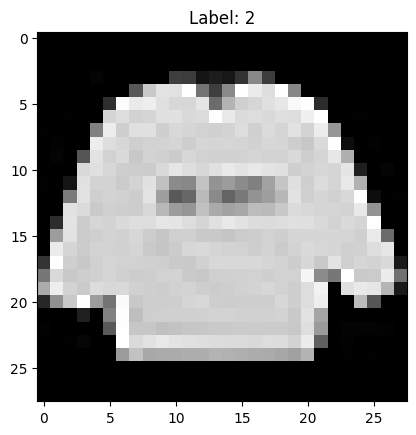

In [13]:
fmnist_train.plot_image(0)

In [14]:
fmnist_train.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59999,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


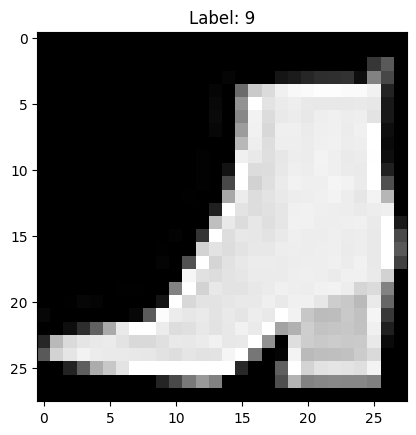

In [15]:
fmnist_train.plot_image((nb_data-1)-5)

## Data functions

In [16]:
def generate_random_one_hot(size):
  label = torch.zeros(size)
  class_idx = torch.randint(0, size-1, (1,))
  label[class_idx] = 1
  return label

In [17]:
def generate_random_seed(size):
  return torch.randn(size)

In [18]:
def generate_random_img(size):
    random_data = torch.rand(size)
    return random_data

##  Test discriminator can separate real data from random noise

In [19]:
D = Discriminator()

In [20]:
epochs = 3

In [21]:
%%time
for epoch in range(epochs):
  print(f'Epoch {epoch+1}/{epochs}')
  for image_tensor, label, label_tensor in fmnist_train:
    # train on real
    D.train(image_tensor, label_tensor, torch.FloatTensor([1]))

    # train on fake
    D.train(generate_random_img(784),
            generate_random_one_hot(10),
            torch.FloatTensor([0]))
    pass
  pass


Epoch 1/3
Loss at step 10000: 2.1584432033705525e-05
Loss at step 20000: 3.8990685425233096e-05
Loss at step 30000: 2.364836291235406e-06
Loss at step 40000: 1.0118130830960581e-06
Loss at step 50000: 8.139191010059221e-08
Loss at step 60000: 4.6750292881370115e-07
Loss at step 70000: 5.5221988759512897e-08
Loss at step 80000: 7.492237941164603e-09
Loss at step 90000: 2.4396903941514836e-10
Loss at step 100000: 3.675511006662191e-09
Loss at step 110000: 1.0374099357335353e-09
Loss at step 120000: 4.392227914706837e-09
Epoch 2/3
Loss at step 130000: 3.209457977160213e-10
Loss at step 140000: 2.0597339112082835e-10
Loss at step 150000: 5.5078643035333386e-11
Loss at step 160000: 5.581110018582081e-10
Loss at step 170000: 4.404782441569388e-11
Loss at step 180000: 1.7370630489565997e-09
Loss at step 190000: 2.044808211643101e-10
Loss at step 200000: 6.095079996271124e-11
Loss at step 210000: 4.184291801934137e-11
Loss at step 220000: 3.637319612170842e-10
Loss at step 230000: 6.0470506380

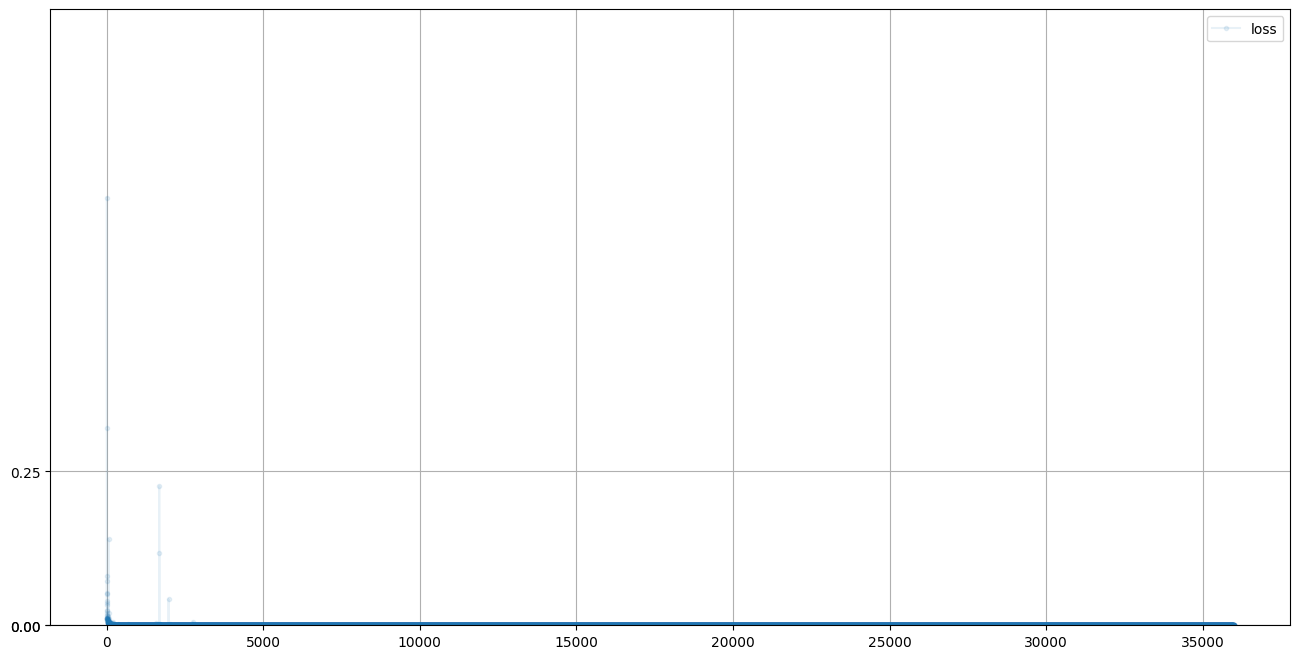

In [22]:
D.plot_progress()

Manually run discriminator to check it can tell real data from fake

In [23]:
import random

In [24]:
# real
for i in range(4):
  image_data_tensor, label, label_tensor = fmnist_train[random.randint(0,nb_data)]
  print( D.forward( image_data_tensor, label_tensor ).item() )
  pass

1.0
1.0
1.0
1.0


In [26]:
# fake
for i in range(4):
  print(D.forward( generate_random_img(784), generate_random_one_hot(10)).item() )
  pass

3.085843212902173e-12
4.4067635825151275e-12
2.5081028833667807e-12
3.2433005933696357e-12


## Teste generator can create fake data

In [27]:
G = Generator()

In [28]:
output = G.forward(generate_random_seed(1), generate_random_one_hot(10))

In [29]:
print(output.shape)

torch.Size([784])


In [30]:
img = output.detach().view(28,28).numpy()

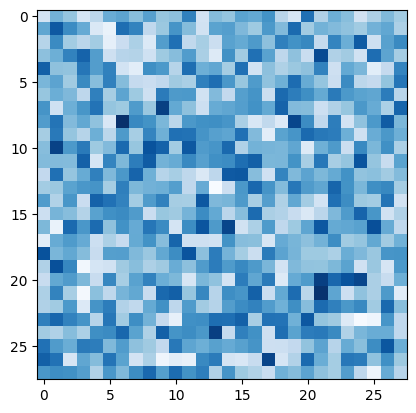

In [31]:
plt.imshow(img, interpolation='none', cmap='Blues')

## Train CGAN

In [32]:
D = Discriminator()

In [33]:
G = Generator()

In [34]:
real_output = torch.FloatTensor([1])

In [35]:
fake_output = torch.FloatTensor([0])

In [36]:
epochs = 12

In [37]:
for ep in range(epochs):
  print(f"Epoch {ep+1}/{epochs}")
  for img_tensor, label, target_tensor in fmnist_train:
    # train D on real data
    D.train(img_tensor, label_tensor, real_output)

    # train D on fake data
    fake_seed = generate_random_seed(1)
    fake_label = generate_random_one_hot(10)
    fake_img = G.forward(fake_seed,fake_label).detach()
    D.train(fake_img, fake_label, fake_output)

    # train G to create real output
    fake_seed = generate_random_seed(1)
    fake_label = generate_random_one_hot(10)
    G.train(D, fake_seed, fake_label, real_output)
    pass

Epoch 1/12
Loss at step 10000: 0.07640676200389862
Loss at step 20000: 0.015601537190377712
Loss at step 30000: 0.004780250135809183
Loss at step 40000: 0.0003559072792995721
Loss at step 50000: 0.14329133927822113
Loss at step 60000: 0.0007143415859900415
Loss at step 70000: 0.0012452080845832825
Loss at step 80000: 0.0001595233625266701
Loss at step 90000: 0.8156384229660034
Loss at step 100000: 0.00019374348630663007
Loss at step 110000: 3.092252154601738e-05
Loss at step 120000: 0.0003272726316936314
Epoch 2/12
Loss at step 130000: 3.21413463097997e-05
Loss at step 140000: 0.00020119198597967625
Loss at step 150000: 4.4863154471386224e-05
Loss at step 160000: 0.00011919730604859069
Loss at step 170000: 2.9146005545044318e-05
Loss at step 180000: 2.1829643515047792e-07
Loss at step 190000: 6.779206887586042e-05
Loss at step 200000: 1.2263091775821522e-05
Loss at step 210000: 1.3014505384489894e-07
Loss at step 220000: 0.05166707560420036
Loss at step 230000: 6.376679095865256e-08
Lo

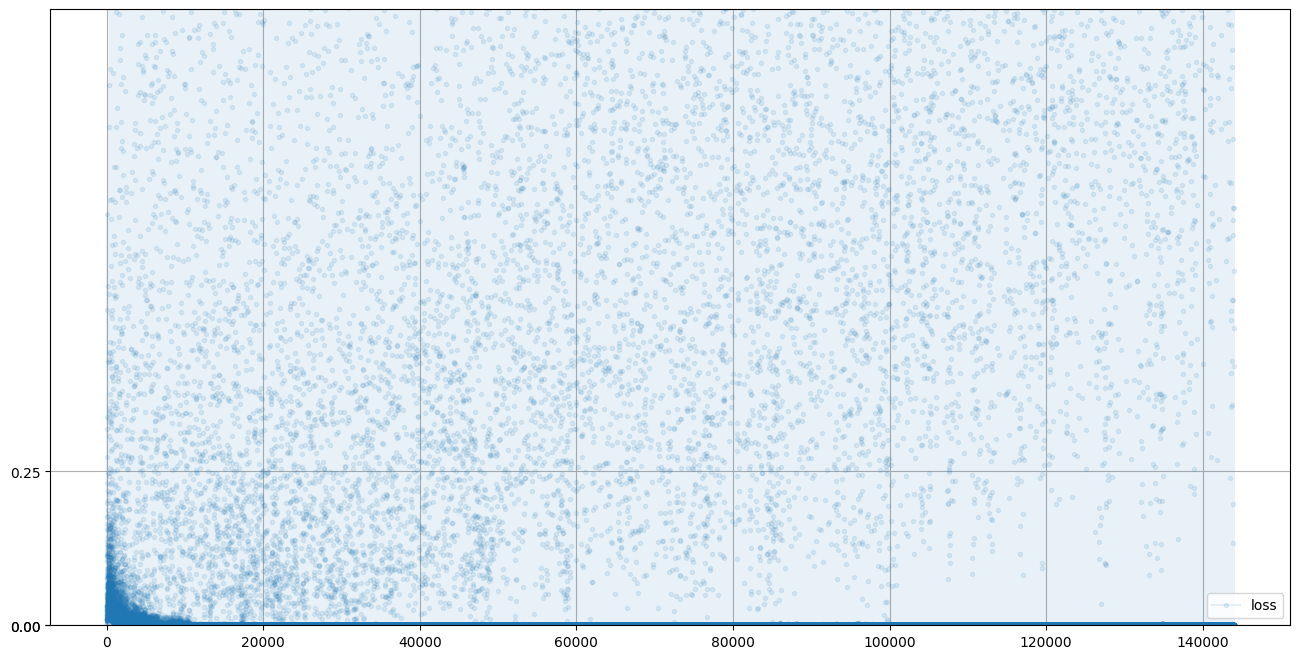

In [42]:
D.plot_progress()

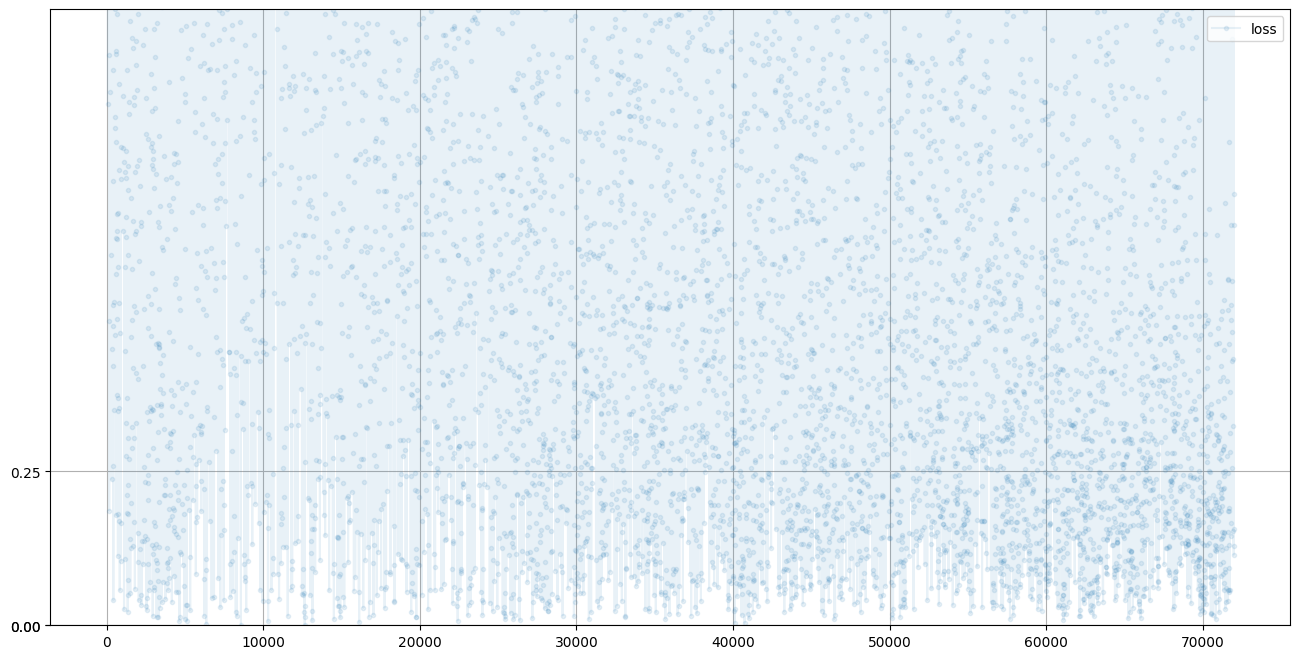

In [45]:
G.plot_progress()

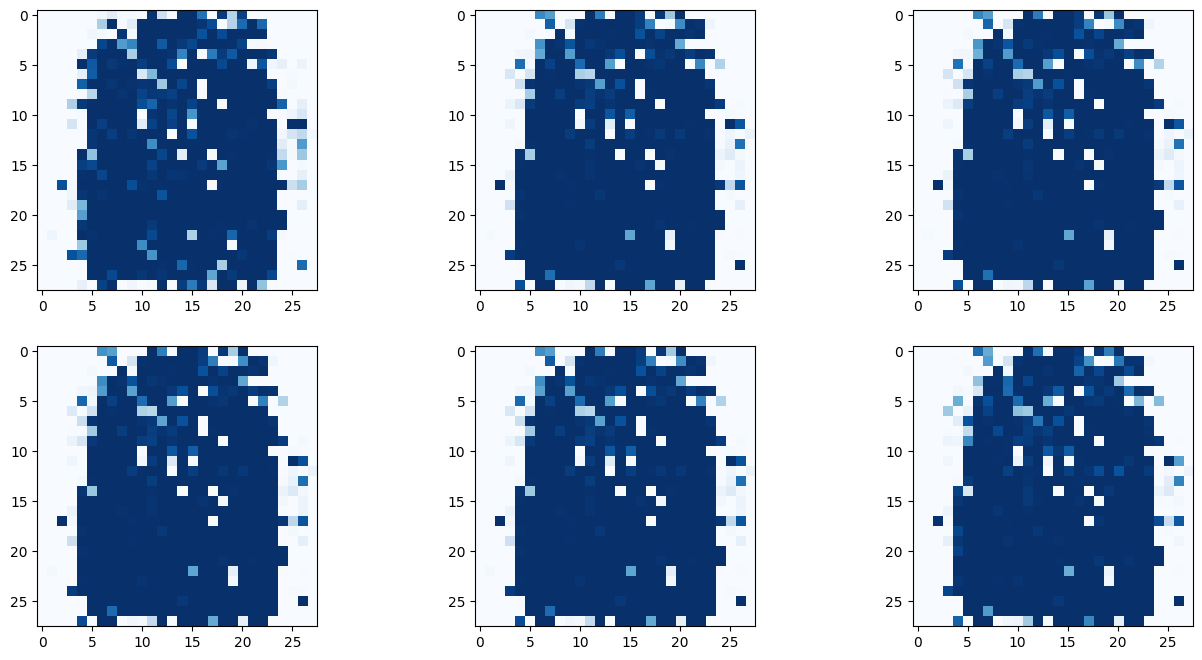

In [46]:
G.plot_images(9)

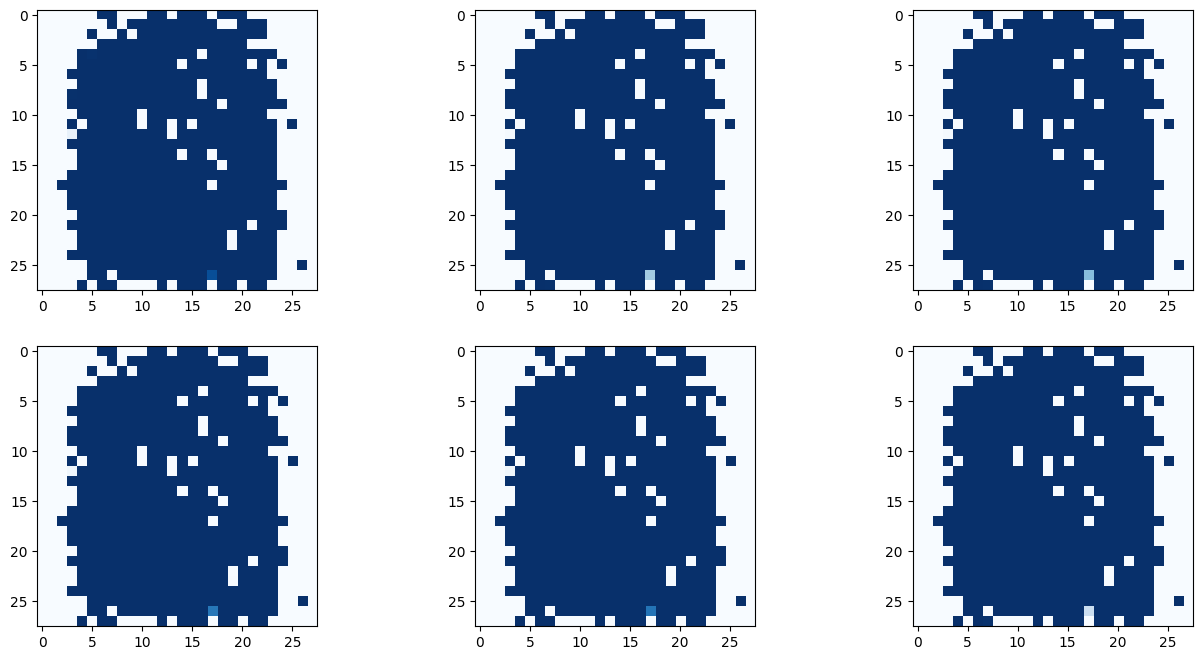

In [47]:
G.plot_images(2)